In [3]:
import datetime
import os
import pathlib

import numpy as np
import pandas as pd

# Current script directory
script_directory = os.path.abspath('')
# Default path of the order database excel file
default_database_path = os.path.join(script_directory, '..', 'data',
                                     "20220706_Auftragsdatenbank.xlsm")

In [16]:
class ShiftModel:
    """Add description
    """

    def __init__(self, current_shift_time, shift_model):
        # TODO: This is just a temporary solution, the values should be read from somewhere else
        # TODO: Move this data structure somewhere else, so it does not have to be loaded with each instantiation
        # Time intervals of each shift model. 0:=Monday, 1:=Tuesday, and so on.
        self.shifts = {'FLEX': {0: [[datetime.time(6, 0), datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(15, 00)]],
                                1: [[datetime.time(6, 0), datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(15, 00)]],
                                2: [[datetime.time(6, 0), datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(15, 00)]],
                                3: [[datetime.time(6, 0), datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(15, 00)]],
                                4: [[datetime.time(6, 0), datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(13, 45)]],
                                5: [[datetime.time(0, 0), datetime.time(0, 0)]],
                                6: [[datetime.time(0, 0), datetime.time(0, 0)]]},
                       'FLEXS': {0: [[datetime.time(15, 0), datetime.time(19, 0)],
                                     [datetime.time(19, 30), datetime.time(23, 45)]],
                                 1: [[datetime.time(15, 0), datetime.time(19, 0)],
                                     [datetime.time(19, 30), datetime.time(23, 45)]],
                                 2: [[datetime.time(15, 0), datetime.time(19, 0)],
                                     [datetime.time(19, 30), datetime.time(23, 45)]],
                                 3: [[datetime.time(15, 0), datetime.time(19, 0)],
                                     [datetime.time(19, 30), datetime.time(23, 45)]],
                                 4: [[datetime.time(14, 0), datetime.time(19, 0)],
                                     [datetime.time(19, 30), datetime.time(23, 30)]],
                                 5: [[datetime.time(0, 0), datetime.time(0, 0)]],
                                 6: [[datetime.time(0, 0), datetime.time(0, 0)]]},
                       'FLEX+S': {0: [[datetime.time(6, 0), datetime.time(12, 30)],
                                      [datetime.time(13, 0),
                                       datetime.time(15, 0)],
                                      [datetime.time(15, 0),
                                       datetime.time(19, 0)],
                                      [datetime.time(19, 30), datetime.time(23, 45)]],
                                  1: [[datetime.time(6, 0), datetime.time(12, 30)],
                                      [datetime.time(13, 0),
                                       datetime.time(15, 0)],
                                      [datetime.time(15, 0),
                                      datetime.time(19, 0)],
                                      [datetime.time(19, 30), datetime.time(23, 45)]],
                                  2: [[datetime.time(6, 0), datetime.time(12, 30)],
                                      [datetime.time(13, 0),
                                       datetime.time(15, 0)],
                                      [datetime.time(15, 0),
                                      datetime.time(19, 0)],
                                      [datetime.time(19, 30), datetime.time(23, 45)]],
                                  3: [[datetime.time(6, 0), datetime.time(12, 30)],
                                      [datetime.time(13, 0),
                                       datetime.time(15, 0)],
                                      [datetime.time(15, 0),
                                      datetime.time(19, 0)],
                                      [datetime.time(19, 30), datetime.time(23, 45)]],
                                  4: [[datetime.time(6, 0), datetime.time(12, 30)],
                                      [datetime.time(13, 0),
                                       datetime.time(13, 45)],
                                      [datetime.time(14, 0),
                                      datetime.time(19, 0)],
                                      [datetime.time(19, 30), datetime.time(23, 30)]],
                                  5: [[datetime.time(0, 0), datetime.time(0, 0)]],
                                  6: [[datetime.time(0, 0), datetime.time(0, 0)]]},
                       'W01S1': {0: [[datetime.time(6, 0), datetime.time(14, 5)],
                                     [datetime.time(14, 10), datetime.time(22, 15)]],
                                 1: [[datetime.time(6, 0), datetime.time(14, 5)],
                                     [datetime.time(14, 10), datetime.time(22, 15)]],
                                 2: [[datetime.time(6, 0), datetime.time(14, 5)],
                                     [datetime.time(14, 10), datetime.time(22, 15)]],
                                 3: [[datetime.time(6, 0), datetime.time(14, 5)],
                                     [datetime.time(14, 10), datetime.time(22, 15)]],
                                 4: [[datetime.time(6, 0), datetime.time(11, 25)],
                                     [datetime.time(11, 30), datetime.time(16, 45)]],
                                 5: [[datetime.time(0, 0), datetime.time(0, 0)]],
                                 6: [[datetime.time(0, 0), datetime.time(0, 0)]]},
                       'W01S3': {0: [[datetime.time(6, 0), datetime.time(23, 55)]],
                                 1: [[datetime.time(0, 0), datetime.time(23, 55)]],
                                 2: [[datetime.time(0, 0), datetime.time(23, 55)]],
                                 3: [[datetime.time(0, 0), datetime.time(23, 55)]],
                                 4: [[datetime.time(0, 0), datetime.time(23, 55)]],
                                 5: [[datetime.time(0, 0), datetime.time(6, 15)]],
                                 6: [[datetime.time(0, 0), datetime.time(0, 0)]]},
                       'W01YL': {0: [[datetime.time(6, 0), datetime.time(21, 45)]],
                                 1: [[datetime.time(6, 0), datetime.time(21, 45)]],
                                 2: [[datetime.time(6, 0), datetime.time(21, 45)]],
                                 3: [[datetime.time(6, 0), datetime.time(21, 45)]],
                                 4: [[datetime.time(6, 0), datetime.time(21, 45)]],
                                 5: [[datetime.time(0, 0), datetime.time(0, 0)]],
                                 6: [[datetime.time(0, 0), datetime.time(0, 0)]]},
                       'W011': {0: [[datetime.time(6, 0), datetime.time(9, 0)],
                                    [datetime.time(9, 15),
                                     datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(17, 30)]],
                                1: [[datetime.time(6, 0), datetime.time(9, 0)],
                                    [datetime.time(9, 15),
                                    datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(17, 30)]],
                                2: [[datetime.time(6, 0), datetime.time(9, 0)],
                                    [datetime.time(9, 15),
                                    datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(17, 30)]],
                                3: [[datetime.time(6, 0), datetime.time(9, 0)],
                                    [datetime.time(9, 15),
                                    datetime.time(12, 30)],
                                    [datetime.time(13, 0), datetime.time(17, 30)]],
                                4: [[datetime.time(6, 0), datetime.time(9, 0)],
                                    [datetime.time(9, 15), datetime.time(13, 0)]],
                                5: [[datetime.time(0, 0), datetime.time(0, 0)]],
                                6: [[datetime.time(0, 0), datetime.time(0, 0)]]}
                       }
        self.company_holidays = [datetime.date(2022, 1, 1),
                                 datetime.date(2022, 4, 15),
                                 datetime.date(2022, 4, 16),
                                 datetime.date(2022, 4, 17),
                                 datetime.date(2022, 4, 18),
                                 datetime.date(2022, 5, 1),
                                 datetime.date(2022, 5, 26),
                                 datetime.date(2022, 5, 27),
                                 datetime.date(2022, 5, 28),
                                 datetime.date(2022, 6, 5),
                                 datetime.date(2022, 6, 6),
                                 datetime.date(2022, 6, 16),
                                 datetime.date(2022, 6, 17),
                                 datetime.date(2022, 6, 18),
                                 datetime.date(2022, 10, 3),
                                 datetime.date(2022, 10, 31),
                                 datetime.date(2022, 11, 1),
                                 datetime.date(2022, 12, 24),
                                 datetime.date(2022, 12, 25),
                                 datetime.date(2022, 12, 26),
                                 datetime.date(2022, 12, 27),
                                 datetime.date(2022, 12, 28),
                                 datetime.date(2022, 12, 29),
                                 datetime.date(2022, 12, 30),
                                 datetime.date(2022, 12, 31),
                                 ]
        if shift_model.lower() not in [i.lower() for i in self.get_shift_names()]:
            raise ValueError(
                f'Object instantiation failed, since "{shift_model}" is not' +
                ' a supported shift model.')
        self.shift_model = shift_model.upper()
        # Set current shift time to the first hour of the next shift day if it
        # is outside the working hours
        self.current_shift_time = self.get_earliest_time(current_shift_time)

    def add_time(self, working_time: int) -> datetime.datetime:
        """Add working time to the current_shift_time and return the new time.

        Parameters
        ----------
        working_time : int
            Time that progresses the shift model time in minutes.

        Returns
        -------
        datetime.datetime
        """
        # TODO: Should the working time be float (e.g. 3.4 minutes)?
        # Then it needs to be converted to seconds
        if isinstance(working_time, datetime.timedelta):
            working_time = working_time.total_seconds() / 60

        # Check if current time is actually during a shift timeframe
        self.current_shift_time = self.get_earliest_time(
            self.current_shift_time)

        while working_time:
            day_shift = self.shifts[self.shift_model][self.current_shift_time.weekday(
            )]
            for interval in day_shift:
                # Check if current time is actually during a shift timeframe
                self.current_shift_time = self.get_earliest_time(
                    self.current_shift_time)
                shift_end = datetime.datetime.combine(self.current_shift_time.date(),
                                                      interval[1])
                if self.current_shift_time > shift_end:
                    # Current shift time does not lie in current interval
                    continue
                # Minutes during this interval
                interval_minutes = (shift_end -
                                    self.current_shift_time).total_seconds() / 60
                if working_time >= interval_minutes:
                    # Whole interval can be worked through
                    working_time -= interval_minutes
                    self.current_shift_time = self.current_shift_time.replace(
                        hour=interval[1].hour,
                        minute=interval[1].minute)
                else:
                    # Work stops during current interval
                    self.current_shift_time += datetime.timedelta(
                        minutes=working_time)
                    working_time = 0
                if not working_time:
                    break
        return self.current_shift_time

    def get_shift_names(self):
        """Returns the names of all available shifts as list of strings.
        """
        return list(self.shifts.keys())

    def get_holidays(self):
        """Returns the holidays as a list.
        """
        return self.company_holidays

    def get_earliest_time(self, start: datetime.datetime) -> datetime.datetime:
        """Returns the earliest time a shift can start after the given time.

        Parameters
        ----------
        start : datetime.datetime
            Time that needs to be adjusted to the next shift start if needed.

        Returns
        -------
        datetime.datetime
            Adjusted time to the next shift start if the input was not in any
            shift timeframes
        """
        # Skip as many days as there are holidays
        while start.date() in self.company_holidays:
            start = start.replace(hour=0, minute=0) + \
                datetime.timedelta(days=1)
        weekday = start.weekday()
        # Iterate through all time intervals of the day and check whether
        # the start time lies in one of those intervals
        for interval in self.shifts[self.shift_model][weekday]:
            if interval[0] <= start.time() < interval[1]:
                # The start time lies between the working hours of the shift
                return start
            elif start.time() < interval[0]:
                # The start time lies before the shift begins,
                # set to shift beginning
                return start.replace(hour=interval[0].hour,
                                     minute=interval[0].minute)
        # The start time does not lie in the working hours of the shift day
        # return the next available day
        # TODO: Check end of year, to jump to next year
        temp_interval = self.shifts[self.shift_model][(weekday + 1) % 6][0]
        day_skips = 1
        if temp_interval[1] == datetime.time(0, 0) and weekday == 5:
            # Saturday, no hours for this shift, get monday
            day_skips = 2
        start = datetime.datetime(start.year, start.month, start.day,
                                  temp_interval[0].hour,
                                  temp_interval[0].minute) + \
            datetime.timedelta(days=day_skips)
        if start.date() in self.company_holidays:
            # New date lies on holiday, calculate new date
            return self.get_earliest_time(start)
        else:
            return start

In [24]:
def get_orders(path: str = default_database_path) -> pd.DataFrame:
    """
    Opens an excel document to return its listed orders as a pandas dataframe.

    Requires the excel document to have following specific structure:
        A sheet named 'Datenbank_Auftragsdaten'.
        The orders starting at row 15.
        Column titles like 'Artikelnummer' and more.

    Parameters
    ----------
    path : str
        Path to the excel order database.

    Returns
    -------
    DataFrame
        Table of orders as pandas dataframe. Column names:
            job, item, order_release, machine, tool, setuptime_material,
            setuptime_coil, duration_machine, duration_hand, deadline,
            calculated_start, calculated_end, planned_start, planned_end,
            actual_start, actual_end
    """
    sheet_name = 'Datenbank_Auftragsdaten'
    # TODO:
    order_df = pd.read_excel(path, sheet_name)  # Read file
    order_df = order_df.rename(columns=order_df.iloc[10])
    # Name first column to reference it for deletion
    order_df = order_df.rename(columns={order_df.columns[0]: 'Nichts'})
    order_df = order_df.drop('Nichts', axis=1)
    # Ignore first 14 rows since data starts at row 15
    order_df = order_df.drop(np.arange(13))
    order_df = order_df.reset_index(drop=True)
    order_df = order_df[['Fertigungsauf-tragsnummer',
                         'Artikelnummer',
                         'Auftragseingabe-zeitpunkt',
                         'Nummer Wickel-rohrmaschine',
                         'Werkzeug-nummer',
                         'Rüstzeit für WKZ/Materialwechsel',
                         'Rüstzeit für Coilwechsel',
                         'Maschinen-laufzeit',
                         'Dauer Handarbeit',
                         'Schichtmodell',
                         'spätester Fertigstellungszeitpunkt',
                         'Spätester Bearbeitungsbeginn',
                         'Berechneter Bearbei-tungsbeginn',
                         'Berechneter Fertigstellungs-zeitpunkt',
                         'PLAN-Bearbeitungs-beginn',
                         'PLAN-Fertigstellungs-zeitpunkt',
                         'IST- Bearbeitungs-beginn',
                         'IST-Fertigstellungs-zeitpunkt']]
    order_df.rename(columns={'Fertigungsauf-tragsnummer': 'job',
                             'Artikelnummer': 'item',
                             'Auftragseingabe-zeitpunkt': 'order_release',
                             'Nummer Wickel-rohrmaschine': 'machine',
                             'Werkzeug-nummer': 'tool',
                             'Rüstzeit für WKZ/Materialwechsel':
                                 'setuptime_material',
                             'Rüstzeit für Coilwechsel': 'setuptime_coil',
                             'Maschinen-laufzeit': 'duration_machine',
                             'Dauer Handarbeit': 'duration_hand',
                             'Schichtmodell': 'shift_model',
                             'spätester Fertigstellungszeitpunkt': 'deadline',
                             'Spätester Bearbeitungsbeginn':
                                 'latest_start',
                             'Berechneter Bearbei-tungsbeginn':
                                 'calculated_start',
                             'Berechneter Fertigstellungs-zeitpunkt':
                                 'calculated_end',
                             'PLAN-Bearbeitungs-beginn':
                                 'planned_start',
                             'PLAN-Fertigstellungs-zeitpunkt':
                                 'planned_end',
                             'IST- Bearbeitungs-beginn':
                                 'actual_start',
                             'IST-Fertigstellungs-zeitpunkt':
                                 'actual_end'},
                    inplace=True)
    return order_df


df = get_orders()
print(df)

             job        item        order_release machine    tool  \
0    92021412719   60PAP2060  2021-09-01 00:00:00    1531  A0 023   
1    92021529395   70AA30000  2021-09-02 00:00:00    1531  A0 023   
2    92021529919       80PAK  2021-09-03 00:00:00    1531  A0 023   
3    92021530000    90APK004  2021-09-04 00:00:00    1531  A0 023   
4    92021539118   55PAP3985  2021-09-05 00:00:00    1535  A0 023   
..           ...         ...                  ...     ...     ...   
185  92021366138   50APK1400  2022-03-05 00:00:00    1532  A0 005   
186  92021365534   25AGA1190  2022-03-06 00:00:00    1536  A0 062   
187  92021376830   50AA61070  2022-03-07 00:00:00    1537  A0 005   
188  92021366434  55APK10000  2022-03-08 00:00:00    1534  A0 012   
189     99876532   20AGA0501  2022-03-14 15:54:55    1536  A0 024   

    setuptime_material setuptime_coil duration_machine duration_hand  \
0                   15              2           323.96           140   
1                   15     

In [25]:
def calculate_end_time(start: datetime.datetime,
                       duration: int,
                       shift_model: str) -> datetime.datetime:
    """
    Calculates the time a job gets finished based on the given duration.

    Takes a start and a duration, and considers company holidays as well as
    operating shifts, to calculate the end time of the finished job and
    returns it.

    Parameters
    ----------
    start : datetime.datetime
        The start time of the job.
    duration : int
        The duration of the job in minutes.
    shift_model : str
        The shift model determines which hours are available for work.
        Possible shift models are:
            Flex, FlexS, Flex+S, W01S1, W01S3, W01YL, W011

    Returns
    -------
    datetime.datetime
        The end time of the job.
    """
    if isinstance(start, pd.Timestamp):
        start = datetime.datetime(start)
    elif isinstance(start, datetime.datetime):
        pass
    else:
        raise ValueError(
            'start parameter needs to be of type datetime.datetime or pandas.Timestamp')

    shifts = ShiftModel(start, shift_model)
    # Add the duration of the job to the current shift time
    current_shift_time = shifts.add_time(datetime.timedelta(minutes=duration))

    return current_shift_time


def calculate_setup_time(tool1: str, tool2: str) -> int:
    """
    Returns 15 if both given tools are not equal, otherwise returns 0.

    Takes two tool names as strings and returns a naive setup time calculation.
    If the same tool is reused for the next order, no setup time is required,
    otherwise a fixed 15 minutes is added to the overall run time.
    The strings are case insensitive and white spaces get removed.

    Parameters
    ----------
    tool1 : str
        Tool name as string e.g. 'A0 023'
    tool2 : str
        Tool name as string e.g. 'A0 023'

    Returns
    -------
    int
        setup time in minutes
    """
    tool1 = str(tool1)
    tool2 = str(tool2)
    # Remove whitespaces and make case insensitive comparison
    if tool1.casefold().replace(' ', '') == tool2.casefold().replace(' ', ''):
        setup_time = 0
    else:
        setup_time = 15
    return setup_time


def naive_termination(order_df, start, last_tool):
    """
    Calculates a simple termination from the given orders and returns it.

    Parameters
    ----------
    order_df: dataframe
        Orders in a dataframe containing the columns:
            machine, job, shift_model, order_release, duration_machine,
            setup_time
        Overwrites the values of following columns:
            calculated_start, calculated_end.
    start: datetime
        The start time of the naive termination calculation.
    last_tool: str
        The last tool name that has been used in the last job before the
        termination.

    Returns
    -------
    dataframe
        The orders with overwritten calculated_start and calculated_end.
    """
    machines = order_df['machine'].astype(int).unique()
    order_df = order_df.assign(setup_time=0)
    # Für jede Maschine
    for machine in machines:
        df_machine = order_df[
            order_df['machine'].astype(int) == machine]
        timestamp = start
        # Entsprechend der Reihenfolge timestamps berechnen
        for index, row in df_machine.iterrows():
            order_num = row['job']
            shift_model = row['shift_model']

            # TODO: What about already running jobs? Or jobs that are finished?
            if timestamp < row['order_release']:
                timestamp = row['order_release']
            # Adjust timestamp to next shift start
            shifts = ShiftModel(timestamp, shift_model)
            timestamp = shifts.get_earliest_time(timestamp)

            order_df.loc[order_df['job'] == order_num,
                         ['calculated_start']] = timestamp
            tool = row['tool']
            setup_time = calculate_setup_time(tool, last_tool)
            order_df.loc[order_df['job'] == order_num,
                         ['setup_time']] = setup_time
            prod_time = int(row['duration_machine'])
            runtime = prod_time + setup_time
            timestamp = calculate_end_time(start=timestamp,
                                           duration=runtime,
                                           shift_model=shift_model)
            order_num = row['job']
            order_df.loc[order_df['job'] == order_num,
                         ['calculated_end']] = timestamp
            last_tool = tool
    return order_df

df.drop(index=df.index[:180], axis=0, inplace=True)
df = naive_termination(df, datetime.datetime(2022, 2, 27, 6, 0, 0), 'A0')
print(df[['order_release', 'machine', 'shift_model', 'duration_machine', 
          'calculated_start', 'calculated_end', 'setup_time']])

           order_release machine shift_model duration_machine  \
180  2022-02-28 00:00:00    1537       W01S3          9000.18   
181  2022-03-01 00:00:00    1537       W01S3         16690.83   
182  2022-03-02 00:00:00    1533       W01S3          1250.24   
183  2022-03-03 00:00:00    1535       W01S3          1220.77   
184  2022-03-04 00:00:00    1532       W01S3          2620.85   
185  2022-03-05 00:00:00    1532       W01S3         12000.52   
186  2022-03-06 00:00:00    1536       W01S3          5700.74   
187  2022-03-07 00:00:00    1537       W01S3           3200.9   
188  2022-03-08 00:00:00    1534       W01S3          2720.18   
189  2022-03-14 15:54:55    1536       W01YL      3830.843169   

        calculated_start       calculated_end  setup_time  
180  2022-02-28 06:00:00  2022-03-07 18:30:00          15  
181  2022-03-07 18:30:00  2022-03-21 21:25:00          15  
182  2022-03-02 00:00:00  2022-03-02 21:05:00          15  
183  2022-03-03 00:00:00  2022-03-03 20:35:0

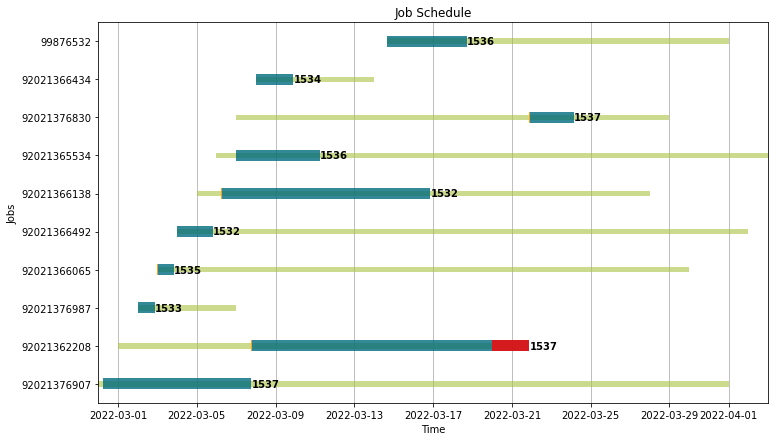

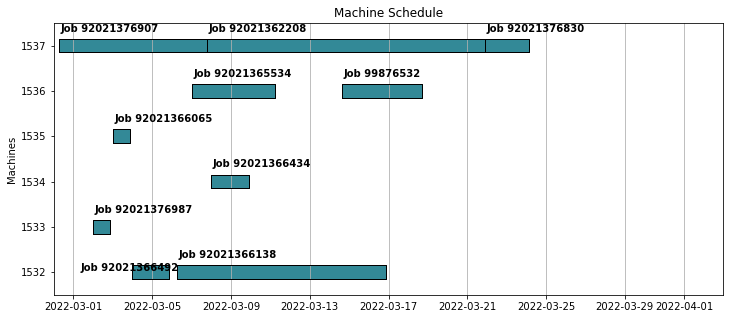

In [26]:
import matplotlib.pyplot as plt
from adjustText import adjust_text
from IPython.display import display

# Colors
ai_marketplace_red = '#d50c2f'
ai_marketplace_red_light = '#f7cfd6'
ai_marketplace_blue_green = '#006C7D'
ai_marketplace_green = '#A9C23F'
ai_marketplace_orange = '#FF9E1B'

def gantt(order_df):
    """Visualize the order table as a Gantt chart as a job and a machine chart.
    """
    bw = 0.3
    fig, axs = plt.subplots(figsize=(12, 0.7 * order_df.shape[0]))
    idx = 0
    for index, row in order_df.iterrows():
        x = row['order_release']
        y = row['deadline']
        axs.fill_between([x, y], [idx - bw / 4, idx - bw / 4],
                         [idx + bw / 4, idx + bw / 4], color=ai_marketplace_green,
                         alpha=0.6, linewidth=0, edgecolor='black')
        x = row['calculated_start']
        y = row['calculated_end']
        axs.fill_between([x, y], [idx - bw / 2, idx - bw / 2],
                         [idx + bw / 2, idx + bw / 2],
                         color=ai_marketplace_blue_green, alpha=0.8,
                         linewidth=0)
        # Color missed deadline in red
        if y > row['deadline']:
            x_missed = row['calculated_end']
            y_missed = row['deadline']
            axs.fill_between([x_missed, y_missed], [idx - bw / 2, idx - bw / 2],
                             [idx + bw / 2, idx + bw / 2],
                             color='red', alpha=0.8,
                             linewidth=0)
        # Setup time in yellow
        y = x + datetime.timedelta(minutes=row['setup_time'])
        axs.fill_between([x, y], [idx - bw / 2, idx - bw / 2],
                         [idx + bw / 2, idx + bw / 2],
                         color=ai_marketplace_orange, alpha=1, linewidth=0)
        # Black bars at beginning and end
        # plt.plot([x, y, y, x, x], [idx - bw, idx - bw,
        #                           idx + bw, idx + bw, idx - bw], color='k')
        # Machine number
        axs.text(row['calculated_end'], idx,
                 str(row['machine']), color='black', weight='bold',
                 horizontalalignment='left', verticalalignment='center')
        idx += 1

    axs.set_ylim(-0.5, idx - 0.5)
    axs.set_title('Job Schedule')
    axs.set_xlabel('Time')
    axs.set_ylabel('Jobs')
    axs.set_yticks(range(len(order_df.index)), order_df.loc[:, 'job'])
    # axs.set_xticks()
    axs.grid(axis='x')
    axs.set_axisbelow(True)
    xlim = axs.set_xlim(order_df['order_release'].min(),
                        order_df['deadline'].max())
    # Highlight holidays
    tmp_shift = ShiftModel(datetime.datetime(2022,1,1), 'flex')
    for holiday in tmp_shift.get_holidays():
        plt.axvspan(holiday, holiday + datetime.timedelta(days=1),
                    facecolor='gray', edgecolor='none', alpha=.5)

    # Machine plot
    # TODO: List all machines, even when not used at all
    machines = sorted([str(i) for i in order_df['machine'].unique()])

    plt.figure(figsize=(12, 5))
    texts = []
    for index, row in order_df.iterrows():
        idx = machines.index(str(row['machine']))
        x = row['calculated_start']
        y = row['calculated_end']
        plt.fill_between([x, y], [idx - bw / 2, idx - bw / 2],
                         [idx + bw / 2, idx + bw / 2],
                         color=ai_marketplace_blue_green, alpha=0.8)
        plt.plot([x, y, y, x, x], [idx - bw / 2, idx - bw / 2,
                                   idx + bw / 2, idx + bw / 2, idx - bw / 2],
                 color='k', linewidth=1)
        texts.append(plt.text(row['calculated_start'], idx + 0.25,
                              'Job ' + str(row['job']), color='black', weight='bold',
                              horizontalalignment='left', verticalalignment='bottom'))
    plt.xlim(xlim)
    plt.ylim(-0.5, len(machines) - 0.5)
    plt.title('Machine Schedule')
    plt.yticks(range(len(machines)), machines)
    plt.ylabel('Machines')
    plt.grid(axis='x')
    adjust_text(texts, only_move={'texts': 'y'})
    plt.show()
    
gantt(df)